# Analyze Performance

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [295]:
repetitions = 10
duration = 20000

start_time = 2000
end_time = start_time + duration

scale_factor = 1 / 100

In [301]:
"""Load data"""

with open('./num-insets.json') as f:
    num_insets = json.load(f)
    num_insets = np.array(num_insets)
    
    # Substract the start time
    num_insets[:,2] -= num_insets[:,2][0]
    
fps_inner = []

for i in range(repetitions):
    with open('inner-fps-{}.json'.format(i)) as f:
        tmp = json.load(f)
        fps_inner.append(np.array(tmp))
        
fps_outer = []

for i in range(repetitions):
    with open('outer-fps-{}.json'.format(i)) as f:
        tmp = json.load(f)
        fps_outer.append(np.array(tmp))

## Align profiles

Since we have to [manually start the performance profiling in Chrome](https://stackoverflow.com/questions/56675684/programmatically-start-the-performance-profiling-in-chrome), we need to first align the frames before it makes sense to aggregate the results.

We know that the animation runs for 20 seconds so we'll have to find the last frame. The initial frames have already been aligned in the data by removing all frames until and inclusive a frame with FPS ~1 or below. Such low FPS are related to a static view before the animation started.

In [307]:
"""Get FPS by milliseconds"""

fps_inner_msec = np.zeros((repetitions, duration))

for r in range(repetitions):
    last = 0
    frames_duration = 1000 / fps_inner[r]
    frames_duration = np.cumsum(frames_duration)
    
    for i in range(frames_duration.size):
        if frames_duration[i] < duration:
            curr = np.int(frames_duration[i])
            fps_inner_msec[r, last:curr] = fps_inner[r][i]
            last = curr
        else:
            fps_inner_msec[r, last:] = fps_inner[r][i]
            break

fps_outer_msec = np.zeros((repetitions, duration))
            
for r in range(repetitions):
    last = 0
    frames_duration = 1000 / fps_outer[r]
    frames_duration = np.cumsum(frames_duration)
    
    for i in range(frames_duration.size):
        if frames_duration[i] < duration:
            curr = np.int(frames_duration[i])
            fps_outer_msec[r, last:curr] = fps_outer[r][i]
            last = curr
        else:
            fps_outer_msec[r, last:] = fps_outer[r][i]
            break

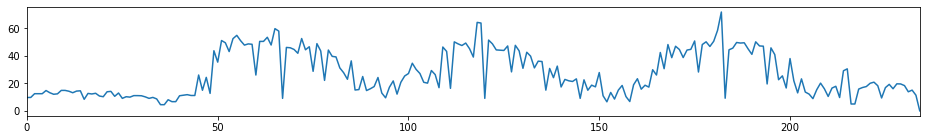

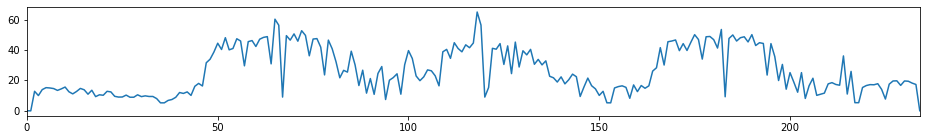

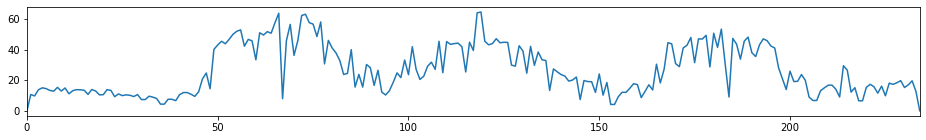

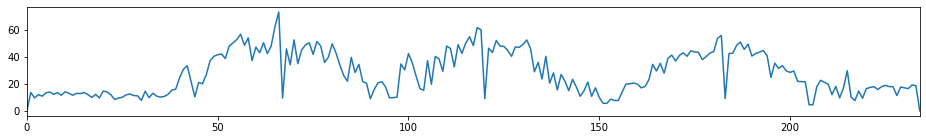

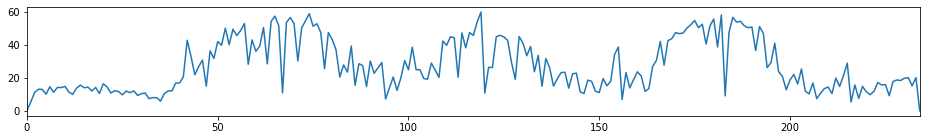

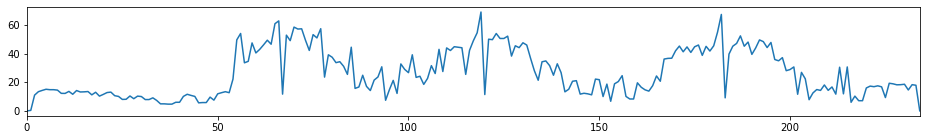

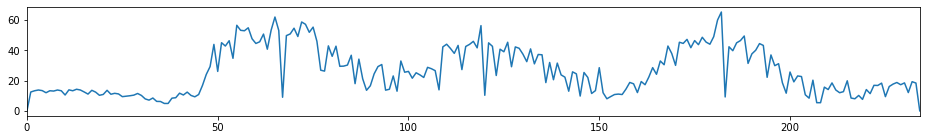

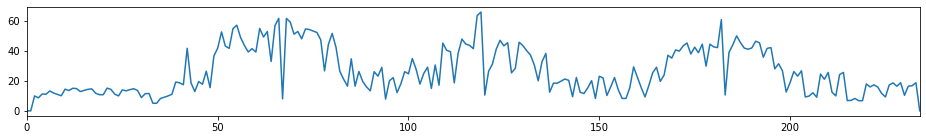

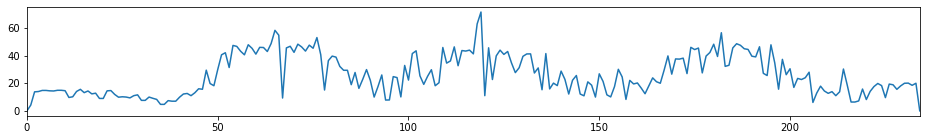

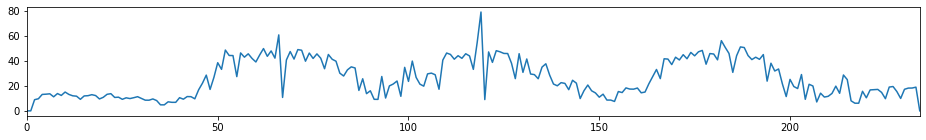

In [185]:
"""Sanity check the FPS per repetition"""

from scipy import ndimage

for i in range(10):
    plt.figure(figsize=(16,2))
    plt.plot(ndimage.zoom(fps_msec[i], scale_factor))
    plt.margins(0, 0.05)
    plt.show()

In [303]:
"""Get number of drawn insets and annotations per milliseconds"""

num_insets_msec = np.zeros(duration)
num_annos_msec = np.zeros(duration)

last = 0
for i in range(num_insets.shape[0]):
    if num_insets[i, 2] > start_time:
        if num_insets[i, 2] <= end_time:
            num_insets_msec[last:num_insets[i, 2]] = num_insets[i, 0]
            num_annos_msec[last:num_insets[i, 2]] = num_insets[i, 1]
            last = num_insets[i, 2]
        else:
            num_insets_msec[last:] = num_insets[i, 0]
            num_annos_msec[last:] = num_insets[i, 1]
            break

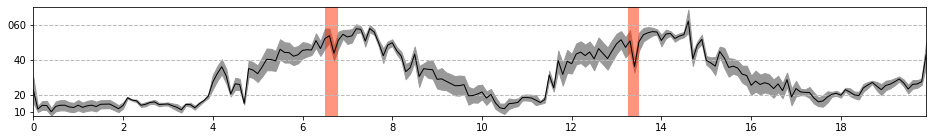

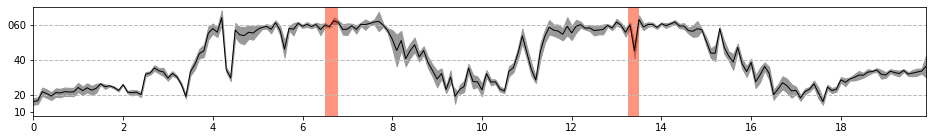

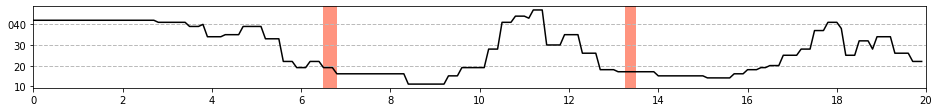

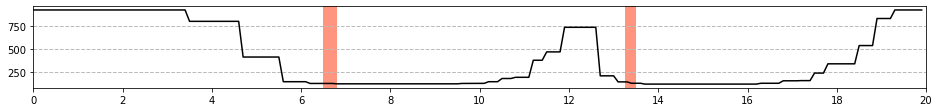

In [328]:
from scipy import stats

x = range(int(duration * scale_factor))
x_ticks = range(0, 220, 20)
x_tick_labels = range(0, 22, 2)

# FPS Inner
mean_fps_inner = ndimage.zoom(np.mean(fps_inner_msec, axis=0), scale_factor, mode='nearest')
se_fps_inner = ndimage.zoom(stats.sem(fps_inner_msec, axis=0), scale_factor, mode='nearest')

plt.figure(figsize=(16,2))
plt.axhline(y=60, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=40, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=20, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.plot(x, mean_fps_inner, color='#000000', linewidth=1)
plt.fill_between(x, mean_fps_inner - se_fps_inner, mean_fps_inner + se_fps_inner, color='#999999')
plt.axvspan(65, 68, facecolor='#FF2B00', alpha=0.5)
plt.axvspan(132.5, 135, facecolor='#FF2B00', alpha=0.5)
# To align the plots by pixels...
plt.yticks([10, 20, 40, 60], ['10', '20', '40', '060'])
plt.xticks(x_ticks, x_tick_labels)
plt.ylim(8, 70)
plt.margins(0)
plt.show()

# FPS Outer
mean_fps_outer = ndimage.zoom(np.mean(fps_outer_msec, axis=0), scale_factor, mode='nearest')
se_fps_outer = ndimage.zoom(stats.sem(fps_outer_msec, axis=0), scale_factor, mode='nearest')

plt.figure(figsize=(16,2))
plt.axhline(y=60, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=40, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=20, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.plot(x, mean_fps_outer, color='#000000', linewidth=1)
plt.fill_between(x, mean_fps_outer - se_fps_outer, mean_fps_outer + se_fps_outer, color='#999999')
plt.axvspan(65, 68, facecolor='#FF2B00', alpha=0.5)
plt.axvspan(132.5, 135, facecolor='#FF2B00', alpha=0.5)
# To align the plots by pixels...
plt.yticks([10, 20, 40, 60], ['10', '20', '40', '060'])
plt.xticks(x_ticks, x_tick_labels)
plt.ylim(8, 70)
plt.margins(0)
plt.show()

# Drawn insets
plt.figure(figsize=(16,1.5))
plt.axhline(y=40, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=30, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=20, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.plot(ndimage.zoom(num_insets_msec, scale_factor), color='#000000')
plt.margins(0, 0.05)
plt.axvspan(65, 68, facecolor='#FF2B00', alpha=0.5)
plt.axvspan(132.5, 135, facecolor='#FF2B00', alpha=0.5)
# To align the plots by pixels...
plt.yticks([10, 20, 30, 40], ['10', '20', '30', '040'])
plt.xticks(x_ticks, x_tick_labels)
plt.show()

# Drawn annotations
plt.figure(figsize=(16,1.5))
plt.axhline(y=750, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=500, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.axhline(y=250, color='#bbbbbb', linestyle='dashed', linewidth=1)
plt.plot(ndimage.zoom(num_annos_msec, scale_factor), color='#000000')
plt.margins(0, 0.05)
plt.axvspan(65, 68, facecolor='#FF2B00', alpha=0.5)
plt.axvspan(132.5, 135, facecolor='#FF2B00', alpha=0.5)
plt.xticks(x_ticks, x_tick_labels)
plt.show()

In [327]:
"""For the Table 2 in the manuscript"""

print(np.round(np.mean(np.mean(fps_inner_msec, axis=0).reshape((10, -1)), axis=1)), np.round(np.mean(fps_inner_msec)))
print(np.round(np.mean(np.mean(fps_outer_msec, axis=0).reshape((10, -1)), axis=1)), np.round(np.mean(fps_outer_msec)))
print(np.round(np.mean(num_insets_msec.reshape((10, -1)), axis=1)))
print(np.round(np.mean(num_annos_msec.reshape((10, -1)), axis=1)))

[14. 15. 35. 51. 32. 21. 47. 45. 23. 24.] 31.0
[22. 31. 54. 59. 38. 40. 59. 53. 25. 32.] 41.0
[42. 40. 33. 18. 14. 36. 22. 15. 26. 30.]
[924. 893. 492. 123. 120. 281. 361. 116. 165. 674.]
